In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

animes_data_path = "./preprocessed_data/preprocessed_animes.csv"
profiles_data_path = "./preprocessed_data/preprocessed_profiles.csv"
reviews_data_path = "./preprocessed_data/preprocessed_reviews.csv"

In [ ]:
animes_data = pd.read_csv(animes_data_path)
profiles_data = pd.read_csv(profiles_data_path)
reviews_data = pd.read_csv(reviews_data_path, engine='python', sep=',', error_bad_lines=False)

<ipython-input-4-39739bd06a7d>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  reviews_data = pd.read_csv(reviews_data_path, engine='python', sep=',', error_bad_lines=False)


In [ ]:
animes = animes_data.copy()
profiles = profiles_data.copy()
reviews = reviews_data.copy()

In [ ]:
from scipy.sparse import coo_matrix
import torch
import torch.nn as nn
import numpy as np

np.random.seed(0)
unique_AnimeID = reviews['anime_uid'].unique()
unique_users = reviews['profile'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_users:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
for i in unique_AnimeID:
    movie_old2new_id_dict[i] = j
    j += 1
    
# Then, use the generated dictionaries to reindex UserID and MovieID in the data_df
user_list = reviews['profile'].values
movie_list = reviews['anime_uid'].values
for j in range(len(reviews)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    movie_list[j] = movie_old2new_id_dict[movie_list[j]]
reviews['profile'] = user_list
reviews['anime_uid'] = movie_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
train_index = np.random.random(len(reviews)) <= 0.7
train_df = reviews[train_index]
test_df = reviews[~train_index]

# generate train_mat and test_mat
num_user = len(reviews['profile'].unique())
num_items = len(reviews['anime_uid'].unique())

train_mat = coo_matrix((train_df['score'].values, (train_df['profile'].values, train_df['anime_uid'].values)), shape=(num_user, num_items)).astype(float).toarray()
test_mat = coo_matrix((test_df['score'].values, (test_df['profile'].values, test_df['anime_uid'].values)), shape=(num_user, num_items)).astype(float).toarray()

## Matrix Factorization using Funk's SVD

In [ ]:
latent_factors = 30

P = np.random.rand(num_user, latent_factors)
Q = np.random.rand(latent_factors, num_items)

a = 0.001
b = 0.1
train_loss = []
test_loss = []
nonzero_indices_train = np.nonzero(train_mat)
nonzero_indices_test = np.nonzero(test_mat)

num_epochs = 30
for epoch in range(num_epochs):
    for i in range(num_user):
        for j in range(num_items):
            if train_mat[i, j] > 0:
                diff = train_mat[i, j] - np.dot(P[i, :], Q[:, j])
                P[i, :] += a * (diff * Q[:, j] - b * P[i, :])
                Q[:, j] += a * (diff * P[i, :] - b * Q[:, j])

    predicted_matrix = np.dot(P, Q)
    
    rmse_train = np.sqrt(np.mean((predicted_matrix[nonzero_indices_train] - train_mat[nonzero_indices_train])**2))
    rmse_test = np.sqrt(np.mean((predicted_matrix[nonzero_indices_test] - test_mat[nonzero_indices_test])**2))

    train_loss.append(rmse_train)
    test_loss.append(rmse_test)

    print('Epoch', epoch + 1, 'of', num_epochs, end=': ')
    print('RMSE Train Loss: {:.4f}'.format(rmse_train), end=', ')
    print('RMSE Test Loss: {:.4f}'.format(rmse_test))

Epoch 1 of 30: RMSE Train Loss: 2.2839, RMSE Test Loss: 2.3163
Epoch 2 of 30: RMSE Train Loss: 2.1538, RMSE Test Loss: 2.2215
Epoch 3 of 30: RMSE Train Loss: 2.0660, RMSE Test Loss: 2.1637
Epoch 4 of 30: RMSE Train Loss: 1.9990, RMSE Test Loss: 2.1233
Epoch 5 of 30: RMSE Train Loss: 1.9446, RMSE Test Loss: 2.0930
Epoch 6 of 30: RMSE Train Loss: 1.8985, RMSE Test Loss: 2.0690
Epoch 7 of 30: RMSE Train Loss: 1.8584, RMSE Test Loss: 2.0493
Epoch 8 of 30: RMSE Train Loss: 1.8230, RMSE Test Loss: 2.0329
Epoch 9 of 30: RMSE Train Loss: 1.7912, RMSE Test Loss: 2.0189
Epoch 10 of 30: RMSE Train Loss: 1.7623, RMSE Test Loss: 2.0069
Epoch 11 of 30: RMSE Train Loss: 1.7359, RMSE Test Loss: 1.9963
Epoch 12 of 30: RMSE Train Loss: 1.7115, RMSE Test Loss: 1.9871
Epoch 13 of 30: RMSE Train Loss: 1.6890, RMSE Test Loss: 1.9788
Epoch 14 of 30: RMSE Train Loss: 1.6679, RMSE Test Loss: 1.9715
Epoch 15 of 30: RMSE Train Loss: 1.6482, RMSE Test Loss: 1.9649
Epoch 16 of 30: RMSE Train Loss: 1.6297, RMSE Tes

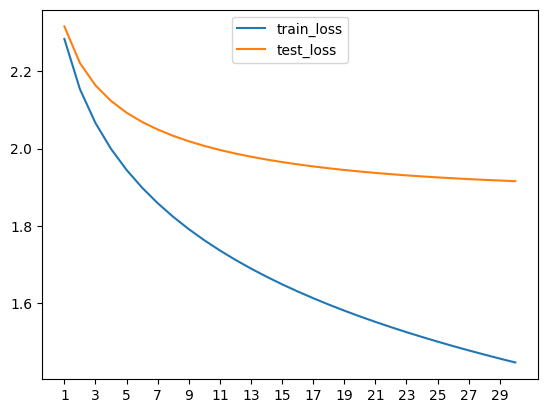

In [ ]:
import matplotlib.pyplot as plt
x = [i + 1 for i in range(num_epochs)]
plt.plot(x, train_loss, label='train_loss')
plt.plot(x, test_loss, label='test_loss')
leg = plt.legend(loc='upper center')
plt.xticks([i + 1 for i in range(0, num_epochs, 2)]) 
plt.show()

## Linear Regression Model

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define the feature matrix as a dictionary of user-item pairs
indices_train = np.argwhere(train_mat > 0)
indices_test = np.argwhere(test_mat > 0)

interactions_train = []
mf_mat = np.dot(P, Q)
scores_train = []
for index in indices_train:
  interactions_train.append({'user': index[0], 'item': index[1]})
  scores_train.append(train_mat[index[0], index[1]])

interactions_test = []
scores_test = []
mf_pred = []
for index in indices_test:
  interactions_test.append({'user': index[0], 'item': index[1]})
  scores_test.append(test_mat[index[0], index[1]])
  mf_pred.append(mf_mat[index[0], index[1]])

vectorizer = DictVectorizer()
interactions_train = vectorizer.fit_transform(interactions_train)
interactions_test = vectorizer.fit_transform(interactions_test)
lr = LinearRegression()
lr.fit(interactions_train.toarray(), scores_train)

# Get the linear regression model's predictions for the feature matrix
lr_predictions = lr.predict(interactions_test)
rmse_lr = np.sqrt(mean_squared_error(scores_test, lr_predictions))
print(rmse_lr)

2.178165688752422


## Ensemble Prediction (Linear Regression + Matrix Factorization)

In [ ]:
test_predictions = 0.75 * np.array(mf_pred) + 0.25 * lr_predictions

# Combine the predictions from the Matrix Factorization model and linear regression models using weighted averaging
rmse_ensemble = np.sqrt(mean_squared_error(scores_test, test_predictions))
print(rmse_ensemble)

1.8980061186860309
